In [1]:
import glob
import pandas as pd
import joblib
import numpy as np

In [2]:
a = pd.read_csv('../../data/aphro_1951_2005.csv')

n_lat = 88
n_lon = 200
n_month = 12
n_year = 55

n_lat_rcm = 80
n_lon_rcm = 180


lats = np.array(a['lat']).reshape(n_year, n_month, n_lon, n_lat)[0, 0, 0, :n_lat_rcm]
lons = np.array(a['lon']).reshape(n_year, n_month, n_lon, n_lat)[0, 0, :n_lon_rcm, 0]
months = np.array(a['month']).reshape(n_year, n_month, n_lon, n_lat)[0, :, 0, 0]
years = np.array([int(i.split('-')[0]) for i in list(a['time'])]).reshape(n_year, n_month, n_lon, n_lat)[:, 0, 0, 0]

lats_l = list(lats)
lons_l = list(lons)
months_l = list(months)
years_l = list(years)

i_2005 = years_l.index(2005)

tps = np.array(a['tp']).reshape(n_year, n_month, n_lon, n_lat)[:i_2005+1, :, :n_lon_rcm, :n_lat_rcm]
years_l = years_l[:i_2005+1]
years = years[:i_2005+1]

del a

In [5]:
rcm_names = sorted(['_'.join(i.split('_')[2:-2]) for i in glob.glob("../../data/historical/bcm_historical_*_1951_2005.csv")])

n_rcms = len(rcm_names)

In [6]:
for i in rcm_names:
    print(i)

CNRM_RCA4
CNRM_RegCM4
CSIRO_RegCM4
CanESM2_RegCM4
ECEARTH_RCA4
GFDL_RCA4
GFDL_RegCM4
IPSL_RCA4
IPSL_RegCM4
MIROC_RCA4
MPI_RCA4
MPI_REMO2009
MPI_RegCM4


In [8]:
rcm_data = [pd.read_csv(f'../../data/historical/bcm_historical_{rcm_name}_1951_2005.csv') for rcm_name in rcm_names]

means = np.full((n_rcms, n_month, n_lon_rcm, n_lat_rcm), np.nan)
vars = np.full((n_rcms, n_month, n_lon_rcm, n_lat_rcm), np.nan)

for i in range(rcm_data[0].shape[0]):
    i_lat = lats_l.index(rcm_data[0].iloc[i]['lat'])
    i_lon = lons_l.index(rcm_data[0].iloc[i]['lon'])
    i_month = months_l.index(rcm_data[0].iloc[i]['month'])

    mean = np.array([rcm_data[j].iloc[i]['mean'] for j in range(len(rcm_names))])
    var = np.array([rcm_data[j].iloc[i]['var'] for j in range(len(rcm_names))])

    means[:, i_month, i_lon, i_lat] = mean
    vars[:, i_month, i_lon, i_lat] = var

del rcm_data

In [10]:
rcm_wass_data = [pd.read_csv(f'../../data/wasserstein/wass_historical_{rcm_name}_1951_2005.csv') for rcm_name in rcm_names]

wasses = np.full((n_rcms, n_month, n_lon_rcm, n_lat_rcm), np.nan)

for i in range(rcm_wass_data[0].shape[0]):
    i_lat = lats_l.index(rcm_wass_data[0].iloc[i]['lat'])
    i_lon = lons_l.index(rcm_wass_data[0].iloc[i]['lon'])
    i_month = months_l.index(rcm_wass_data[0].iloc[i]['month'])

    wass = np.array([rcm_wass_data[j].iloc[i]['wass'] for j in range(len(rcm_names))])

    wasses[:, i_month, i_lon, i_lat] = wass

del rcm_wass_data

In [11]:
lambdas = np.array([np.load(f'../../data/historical/lambda_historical_{rcm_name}_1951_2005.npy') for rcm_name in rcm_names])

In [12]:
import contextlib
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [13]:
from scipy.special import erf

Cs = 0.5*(1 + erf((1/lambdas[:, np.newaxis, np.newaxis, np.newaxis] + means)/np.sqrt(2*vars)))

In [14]:
def p(y, lambda_, mean, var, C):
    return y**(lambda_ - 1)/np.sqrt(2*np.pi*var)*np.exp(-((y**lambda_ - 1)/lambda_ - mean)**2/(2*var))/C

In [15]:
from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

box = 2

def run(i_month, i_lon, i_lat):

    if np.all(np.isnan(tps[:, i_month, i_lon, i_lat])):
        return np.array(np.nan)
    else:
        tp = (tps[:, i_month, max(i_lon-box, 0):min(i_lon+1+box, n_lon_rcm), max(i_lat-box, 0):min(i_lat+1+box, n_lat_rcm)] + 1e-10) # (years, lon_box, lat_box)

        tp = tp.reshape(55, -1) # (years, box)
        # tp_where = ~np.isnan(tp[0])
        tp = tp[:, :][:, :, np.newaxis]

        mean = means[:, i_month, max(i_lon-box, 0):min(i_lon+1+box, n_lon_rcm), max(i_lat-box, 0):min(i_lat+1+box, n_lat_rcm)]
        mean = mean.reshape(n_rcms, -1).T[:, :] # <- [tp_where, :] (box, rcms)

        var = vars[:, i_month, max(i_lon-box, 0):min(i_lon+1+box, n_lon_rcm), max(i_lat-box, 0):min(i_lat+1+box, n_lat_rcm)]
        var = var.reshape(n_rcms, -1).T[:, :]

        C = Cs[:, i_month, max(i_lon-box, 0):min(i_lon+1+box, n_lon_rcm), max(i_lat-box, 0):min(i_lat+1+box, n_lat_rcm)]
        C = C.reshape(n_rcms, -1).T[:, :]

        p_y = (tp)**(lambdas - 1)/np.sqrt(2*np.pi*var)*np.exp(-(((tp)**lambdas - 1)/lambdas - mean)**2/(2*var))/C
        
        p_y = p_y.reshape(-1, n_rcms)
        
        where = ~np.isnan(p_y[:, 0])

        p_y = p_y[where, :]

        wass = wasses[:, i_month, max(i_lon-box, 0):min(i_lon+1+box, n_lon_rcm), max(i_lat-box, 0):min(i_lat+1+box, n_lat_rcm)]
        wass = (wass.reshape(n_rcms, -1).T)[np.newaxis, :, :]
        wass = np.repeat(wass, 55, axis=0)
        wass = wass.reshape(-1, n_rcms)
        wass = wass[where, :]

        def negative_log_likelihood(beta):
            w = softmax(-beta*np.log(wass))
            out = -np.log(np.sum(w*p_y, axis=-1)) # (years, box)
            # out = -np.sum(np.log(np.sum(w*p_y, axis=-1)), axis=(0, 1))
            out = np.sum(out)
            return out
        
        w_ = minimize(negative_log_likelihood, np.array(0.1), bounds=((0., np.inf),)).x

        return float(w_)

run(0, 50, 50)

indices = []
for i_month in range(n_month):
    for i_lon in range(n_lon_rcm):
        for i_lat in range(n_lat_rcm):
            indices.append((i_month, i_lon, i_lat))

with tqdm_joblib(tqdm(desc="My calculation", total=len(indices))) as progress_bar:
    betas = Parallel(n_jobs=8)(delayed(run)(
        *i
    )
    for i in indices)

betas = np.array(betas).reshape(n_month, n_lon_rcm, n_lat_rcm)

My calculation: 100%|██████████| 172800/172800 [00:57<00:00, 3019.71it/s]


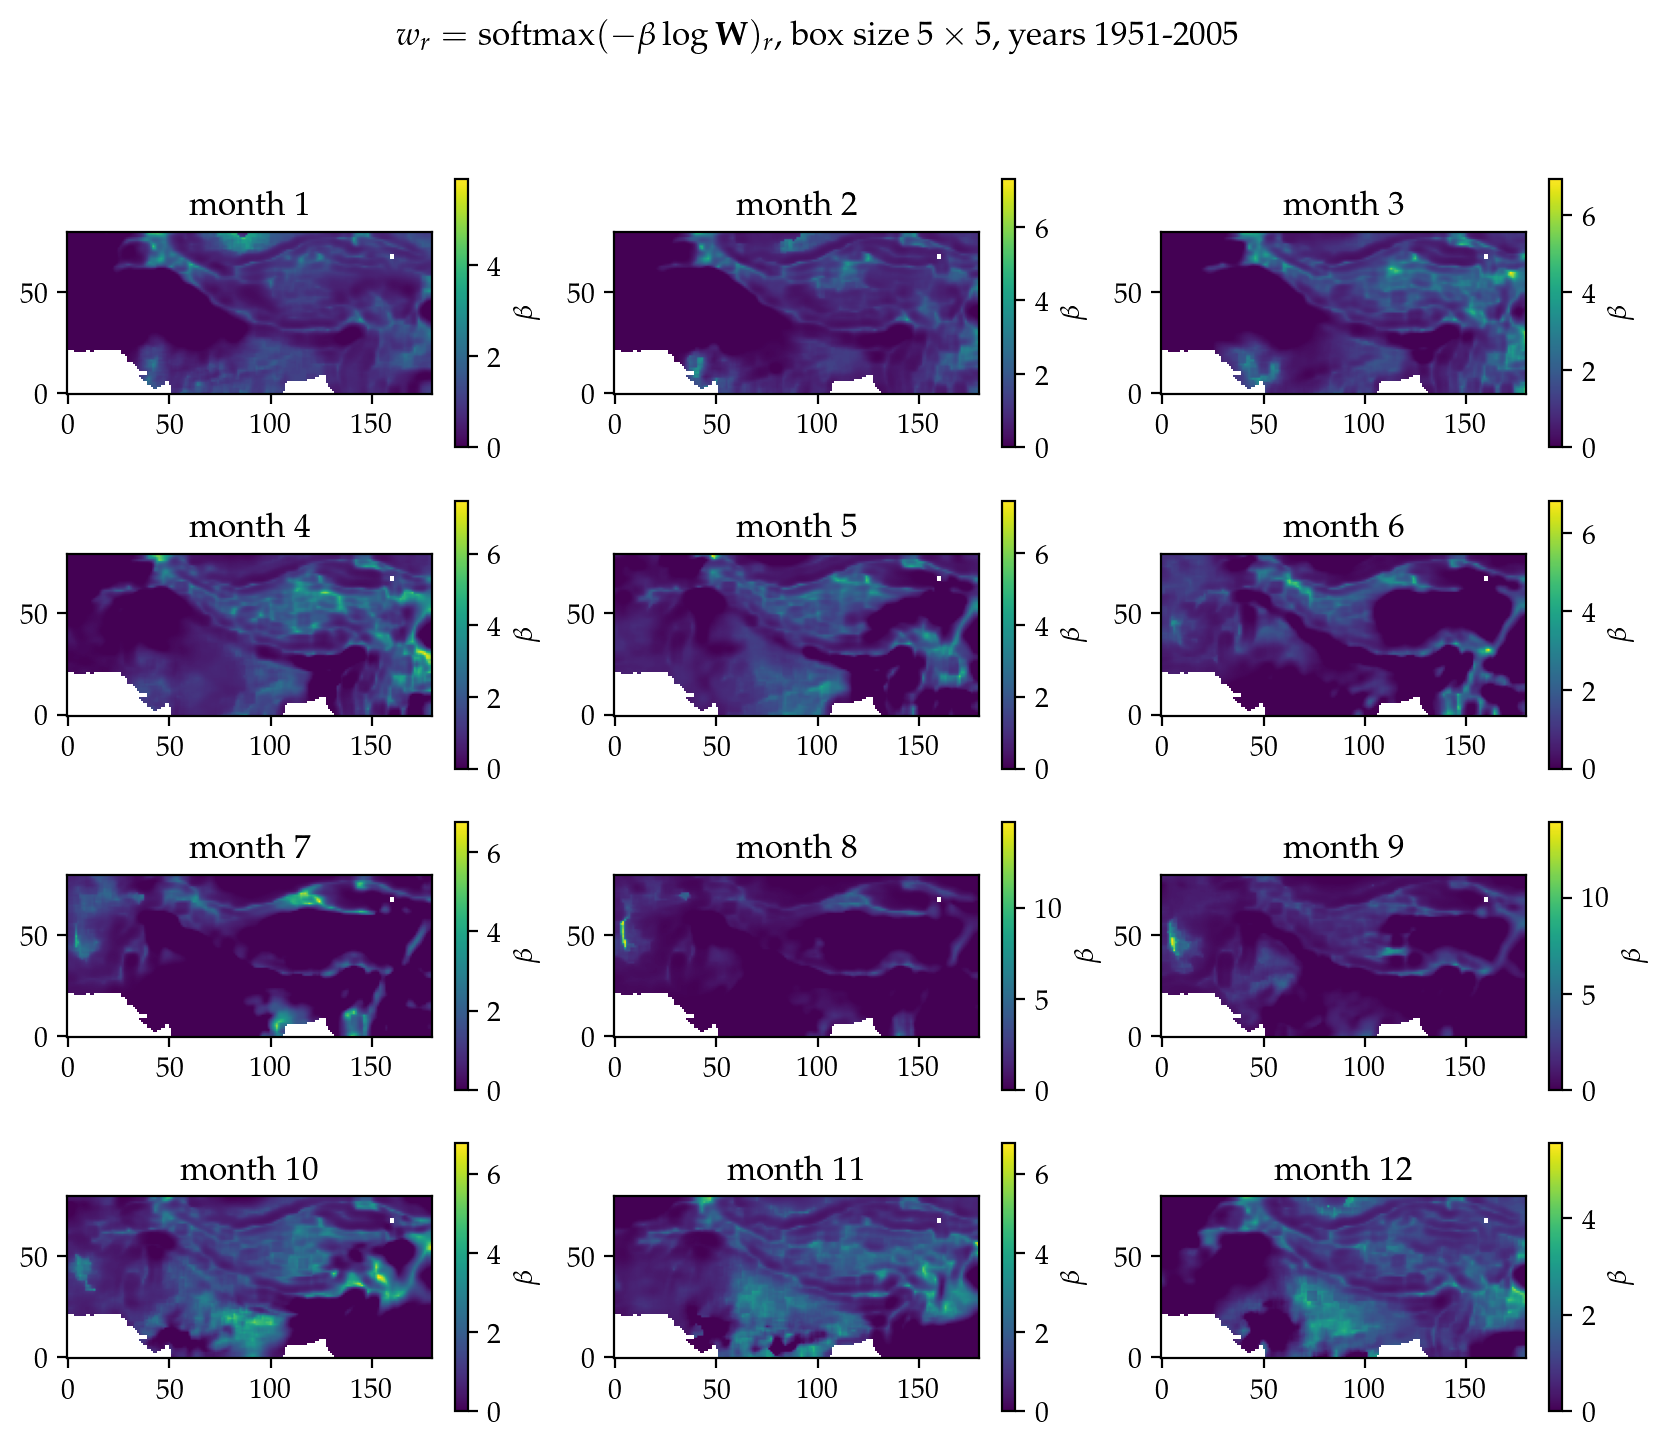

In [16]:
plt.subplots(4, 3, figsize=(10, 8))
plt.suptitle(rf"$w_r = \mathrm{{softmax}}(-\beta \log \mathbf{{W}})_r$, box size ${2*box+1}\times{2*box+1}$, years 1951-2005")

for month in range(12):
    plt.subplot(4, 3, month+1)
    plt.imshow(betas[month, :, :].T, origin='lower')
    plt.colorbar(label=r"$\beta$")
    plt.title(rf"month {month+1}")

In [17]:
ws_beta = softmax(-betas[np.newaxis, :, :, :]*np.log(wasses), axis=0)

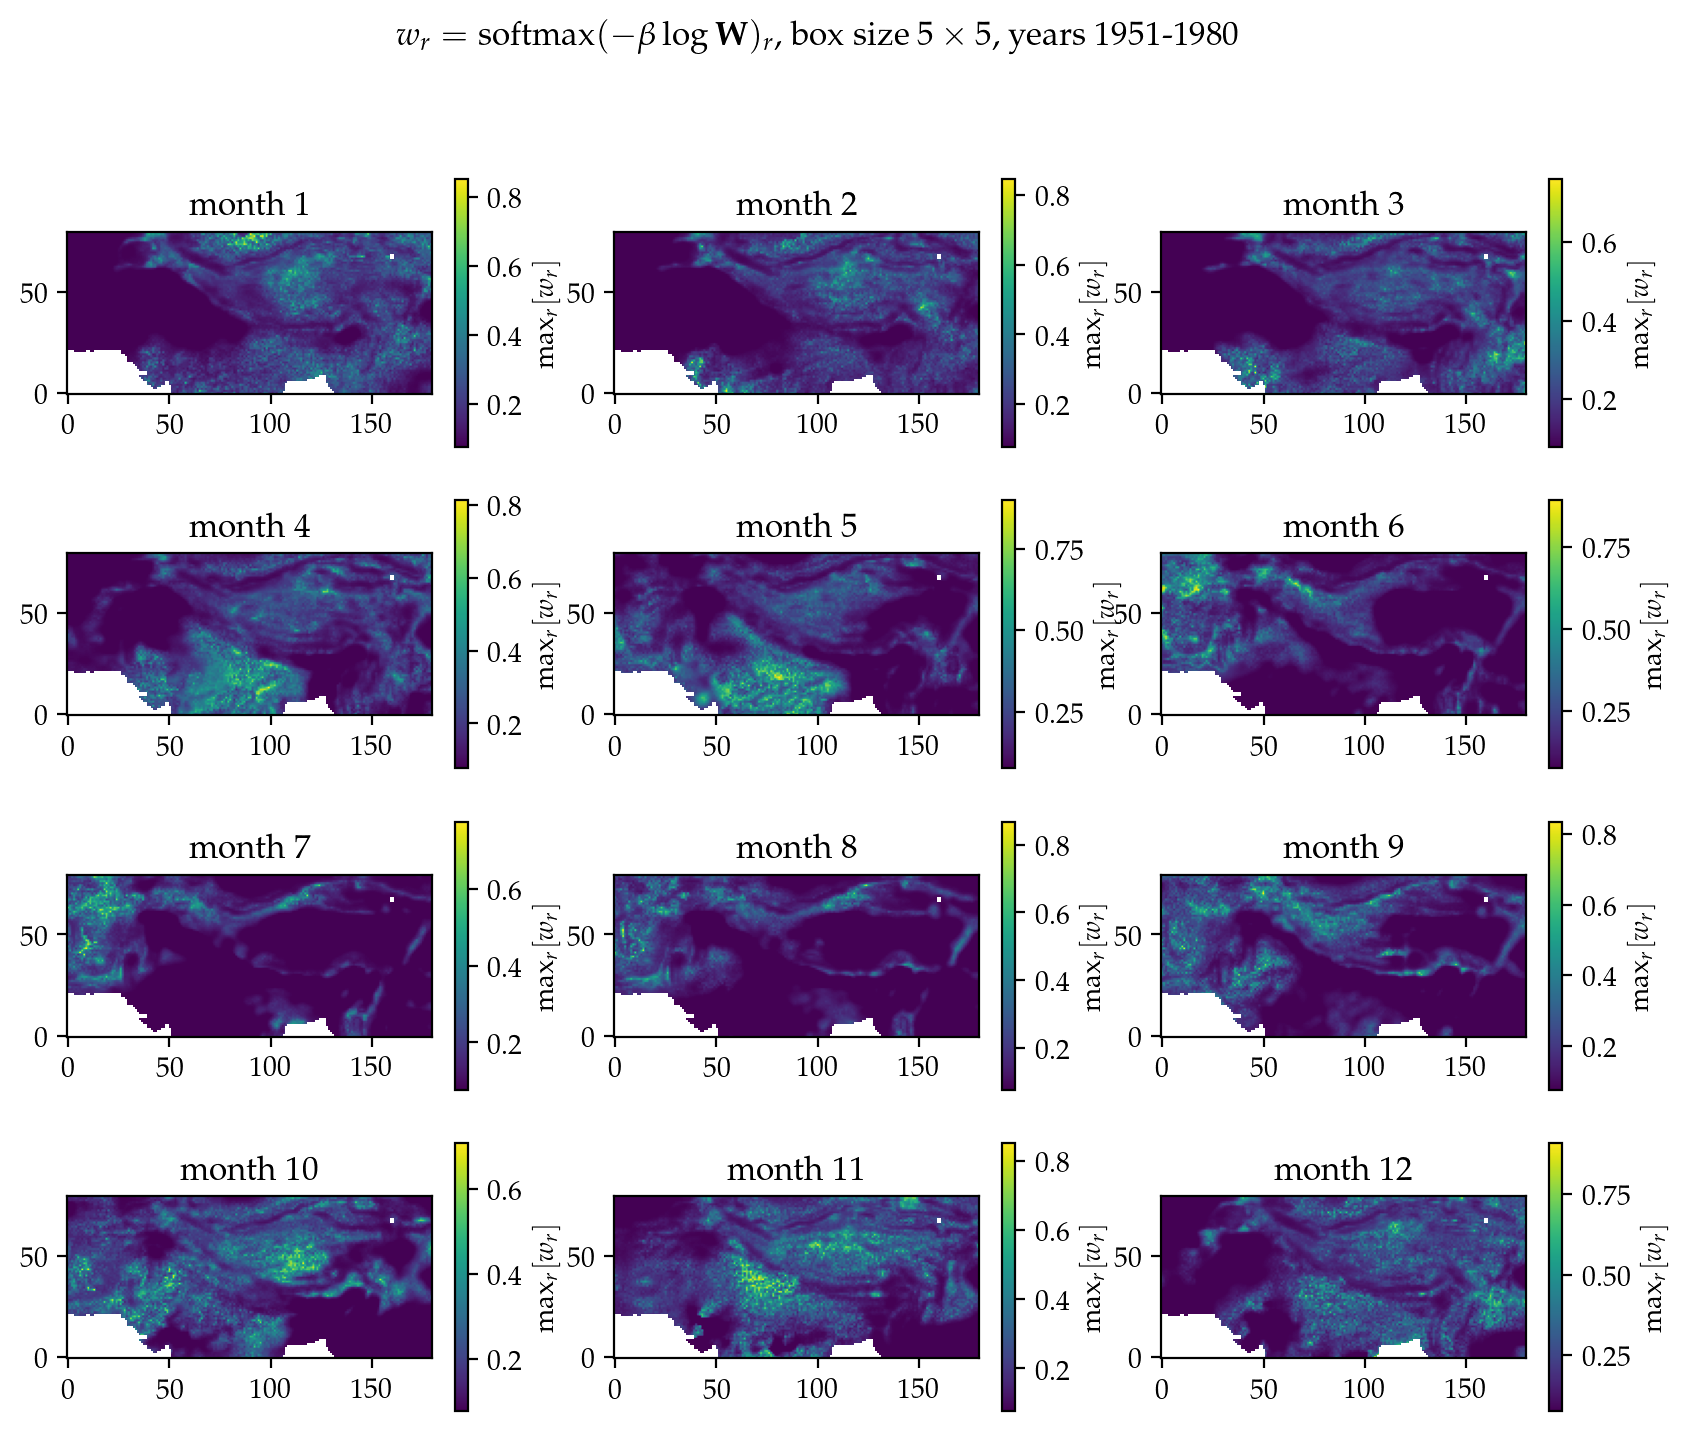

In [18]:
plt.subplots(4, 3, figsize=(10, 8))
plt.suptitle(rf"$w_r = \mathrm{{softmax}}(-\beta \log \mathbf{{W}})_r$, box size ${2*box+1}\times{2*box+1}$, years 1951-1980")

for month in range(12):
    plt.subplot(4, 3, month+1)
    plt.imshow(np.max(ws_beta, axis=0)[month].T, origin='lower')
    plt.colorbar(label=r'$\max_r [w_r]$')
    plt.title(rf"month {month+1}")